In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx
from sklearn.preprocessing import StandardScaler
from semopy import semplot, calc_stats, Model
from IPython.display import Image, Markdown

In [9]:
token_ids = {
    "fed_decision_dec": "74018646712472971445258547247048869505144598783748525202442089895996249694683",
    "btc_price_first": "49827188969931180672229899665706430675722697591952097241424083207067178912799",
    "btc_price_hit_nov": "67085875334869002798733463840730267217253311635510616472551737064503891109620",
    "new_country_buys_btc": "52696967762983156376661808083218380818225074723063198070857375460800745709299"
}

def fetch_polymarket_prices(clob_token_id, interval):
    url = f"https://clob.polymarket.com/prices-history?market={clob_token_id}&interval={interval}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    j = r.json()
    data = j.get("history", [])
    if not data:
        return pd.DataFrame(columns=["date", "price"])
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["t"], unit="s").dt.date
    df = df.groupby("date")["p"].mean().reset_index().rename(columns={"p": "price"})
    return df

def get_btc_data(days):
    url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days={days}"
    r = requests.get(url)
    data = r.json()
    prices = pd.DataFrame(data["prices"], columns=["ts", "btc_price"])
    vols   = pd.DataFrame(data["total_volumes"], columns=["ts", "btc_volume"])
    mcap   = pd.DataFrame(data["market_caps"], columns=["ts", "btc_mcap"])
    df = prices.merge(vols, on="ts").merge(mcap, on="ts")
    df["date"] = pd.to_datetime(df["ts"], unit="ms").dt.date
    df = df[["date", "btc_price", "btc_volume", "btc_mcap"]]
    df_daily = (df.groupby("date").agg(btc_price=("btc_price", "mean"),btc_volume=("btc_volume", "sum"),btc_mcap=("btc_mcap", "mean"),).reset_index())
    return df_daily
btc = get_btc_data(31)
btc.head()

,date,btc_price,btc_volume,btc_mcap
0,2025-10-13,115173.418045,8.315906e+11,2.296038e+12
1,2025-10-14,112669.953477,1.842933e+12,2.245612e+12
2,2025-10-15,111939.730120,1.937868e+12,2.231351e+12
3,2025-10-16,110224.355349,1.738250e+12,2.197420e+12
4,2025-10-17,106865.059111,2.274557e+12,2.130508e+12


In [11]:
dfs = {}
for name, tid in token_ids.items():
    df = fetch_polymarket_prices(tid, interval="max")
    dfs[name] = df.rename(columns={"price": name})
df_merged = None
for name, d in dfs.items():
    if df_merged is None:
        df_merged = d.copy()
    else:
        df_merged = pd.merge(df_merged, d, on="date", how="outer")

btc = get_btc_data(31)
df_merged = pd.merge(df_merged, btc, on="date", how="outer")
df_merged["date"] = pd.to_datetime(df_merged["date"], errors="coerce")
df_merged = df_merged.sort_values("date").reset_index(drop=True)
df_merged = df_merged.set_index("date")
numeric_cols = df_merged.select_dtypes(include=["number"]).columns
df_merged[numeric_cols] = df_merged[numeric_cols].interpolate(method="time").ffill().bfill()
df_merged = df_merged.reset_index()
print(df_merged.shape)
display(df_merged.head())

(32, 8)


,date,fed_decision_dec,btc_price_first,btc_price_hit_nov,new_country_buys_btc,btc_price,btc_volume,btc_mcap
0,2025-10-13,0.065776,0.252963,0.715222,0.149569,115173.418045,8.315906e+11,2.296038e+12
1,2025-10-14,0.061840,0.252963,0.715222,0.149931,112669.953477,1.842933e+12,2.245612e+12
2,2025-10-15,0.048819,0.252963,0.715222,0.169931,111939.730120,1.937868e+12,2.231351e+12
3,2025-10-16,0.050000,0.252963,0.715222,0.187500,110224.355349,1.738250e+12,2.197420e+12
4,2025-10-17,0.102500,0.252963,0.715222,0.195799,106865.059111,2.274557e+12,2.130508e+12


In [12]:
observed_vars = list(dfs.keys()) + ["btc_price"]
print("Using observed vars:", observed_vars)

df_sem = df_merged.copy()
df_sem[observed_vars] = df_sem[observed_vars] * 100  

df_sem = df_sem.dropna(subset=observed_vars, how="all") 
df_sem[observed_vars] = df_sem[observed_vars].ffill().bfill()

X = df_sem[observed_vars].astype(float)
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(X_std.shape)
display(X_std.head())


Using observed vars: ['fed_decision_dec', 'btc_price_first', 'btc_price_hit_nov', 'new_country_buys_btc', 'btc_price']
(32, 5)


,fed_decision_dec,btc_price_first,btc_price_hit_nov,new_country_buys_btc,btc_price
0,1.070228,-0.463099,0.68484,-0.361173,1.720893
1,0.892011,-0.463099,0.68484,-0.349243,1.096293
2,0.302385,-0.463099,0.68484,0.310587,0.914106
3,0.355844,-0.463099,0.68484,0.890229,0.486130
4,2.733219,-0.463099,0.68484,1.164012,-0.351996


In [15]:
model_desc = """
btc_price ~ fed_decision_dec + btc_price_first + new_country_buys_btc + btc_price_hit_nov
btc_price_first ~ fed_decision_dec
new_country_buys_btc ~ fed_decision_dec + btc_price_first
btc_price_hit_nov ~ fed_decision_dec + btc_price_first + new_country_buys_btc
btc_price_first ~~ new_country_buys_btc
"""
print("Columns in X_std:", list(X_std.columns))

Columns in X_std: ['fed_decision_dec', 'btc_price_first', 'btc_price_hit_nov', 'new_country_buys_btc', 'btc_price']



Path coefficients:


/opt/miniconda3/lib/python3.13/site-packages/semopy/stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))


,lval,op,rval,Estimate,p-value
0,btc_price_first,~,fed_decision_dec,-0.415663,9.736180e-03
1,new_country_buys_btc,~,fed_decision_dec,0.672879,9.999998e-01
2,new_country_buys_btc,~,btc_price_first,0.214036,1.000000e+00
3,btc_price_hit_nov,~,fed_decision_dec,0.147251,1.367028e-01
4,btc_price_hit_nov,~,btc_price_first,-0.433413,1.483737e-05
5,btc_price_hit_nov,~,new_country_buys_btc,0.462805,3.669849e-05
6,btc_price,~,fed_decision_dec,-0.168734,1.085062e-01
7,btc_price,~,btc_price_first,-0.000158,9.990250e-01
8,btc_price,~,new_country_buys_btc,-0.128470,3.677425e-01
9,btc_price,~,btc_price_hit_nov,1.073805,3.392016e-09


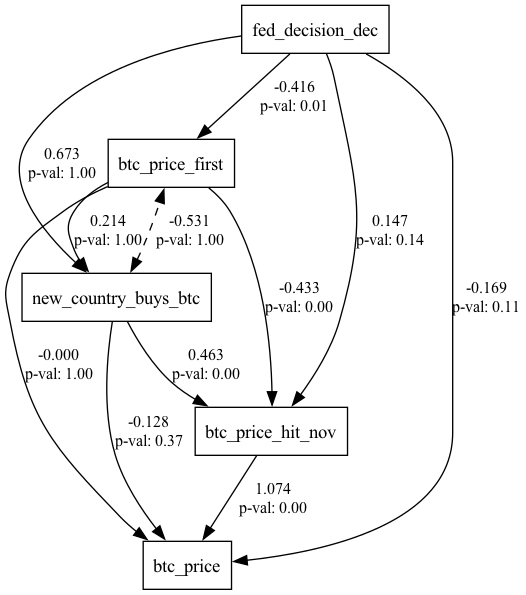

In [17]:
model = Model(model_desc)
model.fit(X_std)
stats = calc_stats(model)
print("\nPath coefficients:")
params = model.inspect() 

cols_to_show = [c for c in ['lval', 'op', 'rval', 'Estimate', 'SE', 'p-value'] if c in params.columns]
display(params[cols_to_show])

semplot(model, "sem_model_graph.png", plot_covs=True)
display(Image(filename="sem_model_graph.png"))